In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import time

2022-11-16 21:08:04.964875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 21:08:05.053132: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-16 21:08:05.074572: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 21:08:05.492324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
tf.__version__
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

2022-11-16 21:08:06.118797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 21:08:06.138802: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-16 21:08:06.138829: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tshegofatso-GE76-Raider-11UG
2022-11-16 21:08:06.138832: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tshegofatso-GE76-Raider-11UG
2022-11-16 21:08:06.138893: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-11-16 21:08:06.138904: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

In [4]:
class MyDense(tf.keras.layers.Layer):
    '''
    Inputs:
    
    units : number of neurons
    initialization = 0,1
           if activations are:
           init =0(He): ReLU, Leaky ReLU, ELU, GELU, Swish, Mish
           init =1(Xavier_Glorot): None, tanh, sigmoid, softmax 
           
    activation: activation to be use either string or callable
    
    
    Output:
            returns activation(wx+b) with appropriate initialization
    
    '''
    def __init__(self, units = 20, initialization=None, activation = None): #None = gives basic activation
        super(MyDense, self).__init__()
        self.units = units   
        self.init = initialization
        
        if activation == 'mish':
            self.activation = tf.keras.activations.get(self.mish_activation)
        else:
            self.activation = tf.keras.activations.get(activation)
       
    @tf.function
    def mish_activation(self, x):
        print(f'called_mish')
    #     mish(x) = xtanh(softsplus(x))  it needs  He initialization
        return x*tf.math.tanh(tf.nn.softplus(x))       
    
    
# We get them from the shape of w= shape
# shape[0] : number of inputs to the neuron
# shape[1] : number of output from the neuron
#     @tf.function(reduce_retracing=True)
    def Xavier_Glorot_initializer(self,shape, dtype=tf.float32):
        '''
        Xavier Glorot: initialization must be used for the following activations:
        None, tanh, sigmoid, softmax

       input: 
            shape = [number of columns, units]

       output:
               samples normal distribution of mean = 0 stddev = sqrt(2./inputs_shape+units)
        '''
        print('Initial weight with  Xavier Glorot ')
        
        shape_to_float = tf.cast(shape, dtype=tf.float32)
        fanin = shape_to_float[0]
        fanout = shape_to_float[1]
        stddev = tf.sqrt(2. /(fanin+fanout)  )
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)
    
#     @tf.function(reduce_retracing=True) 
    def He_initializer(self,shape,dtype = tf.float32):
        '''
        input: 
                shape = [number of columns, units]

        He (aka He normal)initialization must be used for the following activations:
        ReLU, Leaky ReLU, ELU, GELU, Swish, Mish

        He initialization:
        random normal with variance and mean of 2/fanin = 2/no. of inputs = 2/inputs
        '''
        shape_to_float = tf.cast(shape, dtype=tf.float32)
#         print(f'INIT shape = {shape}, dtype = {shape.dtype}')
#         fanin = tf.constant(shape[0], dtype = tf.float32)
        fanin = shape_to_float[0]
#         print(f'fanin = {fanin}')
        stddev = tf.sqrt(2. /fanin)
#         print(f'stddev = {stddev}')
        print('Initial weight with  He')
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)        

#     Initialize kernel aka w
    def init_w(self, input_shape):
        shape = [input_shape[-1], self.units]
        shape = tf.constant(shape, dtype=tf.int32)

        if self.init == 0:
#             Initialize with He : Relu and variants activation functions
            value = self.He_initializer(shape)
        else:
#             Initialize with Xavier_Glorot : None, tanh, sigmoid, softmax activation functions
            value = self.Xavier_Glorot_initializer(shape)
            
        return tf.Variable(name = 'kernel', initial_value=value ,trainable = True )

#     Initialize biase aka b
    def init_b(self):
        value = tf.zeros(self.units)
        return tf.Variable(name = 'bias', initial_value=value ,trainable = True )    
       
        
    def build(self, input_shape):
        self.w = self.init_w(input_shape)
        self.b = self.init_b()
        
    def call(self, inputs):
        out_put = self.activation(tf.matmul(inputs, self.w) + self.b)
        return out_put

In [5]:
class Z_approx(tf.keras.Model):
    def __init__(self,num_of_hid_layers = None, units_per_layer = None, num_out=1, initialization=None, activation=None ):
        super(Z_approx,self).__init__()
        self.num_of_hid_layers = num_of_hid_layers
        self.units_per_layer = units_per_layer
        self.num_out = num_out
        self.init = initialization
        self.normalize = tf.keras.layers.Normalization()
        
        if self.init == 0:
            kerner_init = tf.keras.initializers.he_normal()
        else:
            kerner_init = tf.keras.initializers.glorot_normal()
            
        
        
        
        self.initialization = initialization
        self.activation = activation
        
        
        self.hidden_layers = [MyDense(self.units_per_layer, self.initialization, self.activation) 
                              for _ in range(self.num_of_hid_layers)]
        
        self.out = MyDense(units=self.num_out, initialization=self.initialization)
        
        self.bn = [tf.keras.layers.BatchNormalization() for _ in range(self.num_of_hid_layers)]
    
    def call(self, inputs):
        '''
        Add BN before since the layer includes activations
        
        '''
        
        for i in range(self.num_of_hid_layers):
            if i == 0:
                x = self.normalize(inputs)
                x = self.bn[i](x)
            else:
                x = self.bn[i](x)
                
            x = self.hidden_layers[i](x)
            
        return self.out(x)          

In [6]:
t = tf.linspace(0,1,2000)[:,tf.newaxis]
t.shape

TensorShape([2000, 1])

In [7]:
z_hat = Z_approx(num_of_hid_layers = 10, units_per_layer = 30, num_out=4, initialization = 0,activation = 'mish')
z_hat.build(t.shape)

Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He


In [8]:
z_hat(t).shape
# remember z1 = u1 + iv1; z2 = u2 + iv2 hence 4

TensorShape([2000, 4])

In [34]:
def equations(u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt):
#     derivatives must be dtype tf.float32
#     dz1dt = -ikz2*
#     dz2dt = -ikz1*
    k = tf.constant(1.,dtype = tf.float32)
    k = tf.complex(k,0.0)
    dz1dt = tf.complex(du1dt,dv1dt) # dzdt1 = dudt + idvdt . 
    dz2dt = tf.complex(du2dt,dv2dt) # dzdt1 = dudt + idvdt . 
    
    
    z1 = tf.complex(u1,v1)
    z2 = tf.complex(u2,v2)
    
    rhs1 = -k*z2*1.j
    rhs2 = -k*z1*1.j
    
#     real(LHS)-Real(RHS) = -Imag(LHS)+Img(RHS) Equation from PINN paper
    
    f_real1 = tf.math.real(dz1dt) - tf.math.real(rhs1) # = real(LHS)-Real(RHS)
    f_imag1 = -tf.math.imag(dz1dt) + tf.math.imag(rhs1) # = -Imag(LHS)+Img(RHS)
    
    f_real2 = tf.math.real(dz2dt) - tf.math.real(rhs2) # = real(LHS)-Real(RHS)
    f_imag2 = -tf.math.imag(dz2dt) + tf.math.imag(rhs2) # = -Imag(LHS)+Img(RHS)    
    
    
    return f_real1,f_imag1,f_real2,f_imag2

In [35]:
def get_derivatives(t):
    '''
    Calculate the derivatives and function that correspond to the ode

    input:
            t : independent variant

    output:
            value and corresponding derivative

    '''

#         z = u + iv
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)    
        u1 = z_hat(t)[:,:1]
        v1 = z_hat(t)[:,1:2] 
        u2 = z_hat(t)[:,2:3]
        v2 = z_hat(t)[:,3:4]     
    du1dt = tf.cast(tape.gradient(u1,t), dtype=tf.float32)
    dv1dt =  tf.cast(tape.gradient(v1,t),dtype=tf.float32)
    du2dt = tf.cast(tape.gradient(u2,t), dtype=tf.float32)
    dv2dt =  tf.cast(tape.gradient(v2,t),dtype=tf.float32)            

    del tape

    return u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt

In [36]:
u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt = get_derivatives(t)

In [41]:
v2

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[-0.00207001],
       [-0.00256708],
       [-0.00306386],
       ...,
       [-1.1760409 ],
       [-1.1770627 ],
       [-1.1780844 ]], dtype=float32)>

In [44]:
dv1dt.shape

TensorShape([2000, 1])

In [45]:
du1dt+v2 == (dv1dt-u2)

<tf.Tensor: shape=(2000, 1), dtype=bool, numpy=
array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])>

In [9]:
class PINN:
    def __init__(self, t, model,z_init,optim):
        self.model = model
        self.t = t
        self.u1_init = z_init[0]
        self.v1_init = z_init[1]
        self.u2_init = z_init[2]
        self.v2_init = z_init[3]        
        self.optim = optim

        
    def get_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivative

        '''
        
#         z = u + iv
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)    
            u1 = self.model(t)[:,:1]
            v1 = self.model(t)[:,1:2] 
            u2 = self.model(t)[:,2:3]
            v2 = self.model(t)[:,3:4]     
        du1dt = tf.cast(tape.gradient(u1,t), dtype=tf.float32)
        dv1dt =  tf.cast(tape.gradient(v1,t),dtype=tf.float32)
        du2dt = tf.cast(tape.gradient(u2,t), dtype=tf.float32)
        dv2dt =  tf.cast(tape.gradient(v2,t),dtype=tf.float32)            
  
        del tape
        
        return u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt
    
    def equations(self, u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt):
        #     derivatives must be dtype tf.float32
        #     derivatives must be dtype tf.float32
        #     dz1dt = -ikz2*
        #     dz2dt = -ikz1*
        k = tf.constant(1.,dtype = tf.float32)
        k = tf.complex(k,0.0)
        dz1dt = tf.complex(du1dt,dv1dt) # dzdt1 = dudt + idvdt . 
        dz2dt = tf.complex(du2dt,dv2dt) # dzdt1 = dudt + idvdt . 


        z1 = tf.complex(u1,v1) #z1 = u1 + iv1
        z2 = tf.complex(u2,v2)

        z1_star = tf.math.conj(z1)   #z1* = complex conjugate (z1)
        z2_star = tf.math.conj(z2)   #z2* = complex conjugate (z1)
        
        rhs1 = -k*z2_star*1.j
        rhs2 = -k*z1_star*1.j

    #     real(LHS)-Real(RHS) = -Imag(LHS)+Img(RHS) Equation from PINN paper

        f_real1 =  tf.math.real(dz1dt) - tf.math.real(rhs1) # = real(LHS)-Real(RHS)
        f_imag1 = -tf.math.imag(dz1dt) + tf.math.imag(rhs1) # = -Imag(LHS)+Img(RHS)

        f_real2 =  tf.math.real(dz2dt) - tf.math.real(rhs2) # = real(LHS)-Real(RHS)
        f_imag2 = -tf.math.imag(dz2dt) + tf.math.imag(rhs2) # = -Imag(LHS)+Img(RHS)    


        return f_real1,f_imag1,f_real2,f_imag2
        
    def ode_ic(self,t):
        u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt  = self.get_derivatives(t)
        f_real1,f_imag1,f_real2,f_imag2 = self.equations(u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt)
        u1 =  f_real1
        u2 =  f_imag1
        u3 =  f_real2
        u4 =  f_imag2        
        
#         Initial conditions
        u10,v10,u20,v20,_,_,_,_= self.get_derivatives(tf.zeros_like(t))
#        
        u5 = u10  - self.u1_init
        u6 = v10  - self.v1_init
        u7 = u20  - self.u2_init
        u8 = v20  - self.v2_init
        return u1,u2,u3,u4,u5,u6,u7,u8
        
    def loss(self,t):
        u1,u2,u3,u4,u5,u6,u7,u8 = self.ode_ic(t)
        mse_u1  = tf.reduce_mean(tf.square(u1))
        mse_u2  = tf.reduce_mean(tf.square(u2))
        mse_u3  = tf.reduce_mean(tf.square(u3))
        mse_u4  = tf.reduce_mean(tf.square(u4))
        
        mse_u5  = tf.reduce_mean(tf.square(u5))
        mse_u6  = tf.reduce_mean(tf.square(u6))
        mse_u7  = tf.reduce_mean(tf.square(u7))
        mse_u8  = tf.reduce_mean(tf.square(u8))        
        
        mse_t = mse_u1+mse_u2 + mse_u3+mse_u4+mse_u5+mse_u6+mse_u7+mse_u8

        return mse_t
    
    def train_with_adam(self,batch_mode,epochs,batch_size,t):
        @tf.function
        def train_and_update(t):
    #         print(f'params : \n {self.model.trainable_variables}')
            with tf.GradientTape() as tape:
#                 tape.watch(model.trainable_variables)
                los  = self.loss(t)
            dlossdpa = tape.gradient(los,self.model.trainable_variables) 
            self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
            return los
        
        def train_and_update_batch(epochs, batch_size,t):
            loss_batch = []
            steps_per_epoch = int(t.shape[0]/batch_size)
            
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}\n')
            
            for epoch in range(epochs):
#                 print(f'Epoch {epoch} ', end = ".")
                for i in range(steps_per_epoch):
                    t_batch = t[i*batch_size:batch_size*(i+1)]
                    loss = train_and_update(t_batch).numpy()
                    loss_batch.append(loss)
                    
#                     if i%(steps_per_epoch/10)==0:
#                         print(end=".")
                        
#                     if epoch>6:
#                         if tf.reduce_all(loss_batch[-1]<loss_batch[-6:-1]):
#                             self.model.save_weights('saved_model'+str(loss_batch[-1]))
#                             print(f'\n best loss for epoch {epoch} : {loss_batch[-1]}') 
                        
                        
                if epoch%1000==0:   
                    print(f'\n loss for epoch {epoch} : {loss}')  
            print(f'Final loss : {loss}')    
            return loss_batch      
                        
                        
        def train_whole_set(t):                
            losses =[]
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            losses.append(initial_loss)

            for epoch in range(epochs):
            #     print(f'epoch {epoch}')
            #     print('epoch {}'.format(epoch),end = ".")
                loss = train_and_update(t).numpy()
                losses.append(loss)
            #     print(f'loss : {loss}')
#                 if epoch>5:
#                     if tf.reduce_all(losses[-1]<losses[-5:-1]):
#                         self.model.save_weights('saved_model'+str(losses[-1]))
#                         print(f'\n best loss so far epoch {epoch} : {losses[-1]}')            

                if epoch%1000==0:
                    print(f'loss for epoch {epoch} : {loss}') 
            #         print(end = ".")
            print(f'Final loss : {loss}') 
            return losses
        
        if batch_mode == True:
            losses = train_and_update_batch(epochs, batch_size,t)
        else:
            losses = train_whole_set(t)
            
        return losses                

In [10]:
optim = tf.keras.optimizers.Adam()
epochs = 5000
batch = 100
u10,v10,u20,v20 = 1.,0.,1.,0.

z_init = tf.constant(np.array([u10,v10,u20,v20]), dtype=tf.float32)
# New idea z = [x,y]
z_init

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 0., 1., 0.], dtype=float32)>

In [11]:
pinn = PINN(t, z_hat,z_init,optim)

In [12]:
# batch_mode=False means without batches
start = time.time()
losss =  pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in {time.time() -start} s')

initial loss : 4.926397323608398
loss for epoch 0 : 3.24076771736145
loss for epoch 1000 : 1.6653108104947023e-05
loss for epoch 2000 : 1.8826203813659959e-06
loss for epoch 3000 : 6.998661774559878e-07
loss for epoch 4000 : 1.1202565701751155e-06
Final loss : 2.4507599505341204e-07
final loss 2.4507599505341204e-07 in 197.35772371292114 s


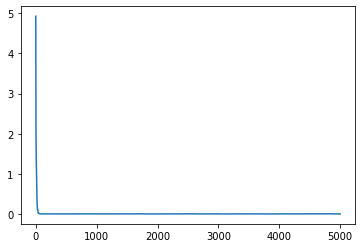

In [13]:
plt.plot(losss)

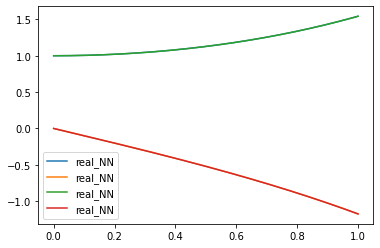

In [14]:
# True solutions
# u1_true = lambda t : (tf.math.exp(t)+tf.math.exp(-t))
# v1_true = lambda t :  (tf.math.exp(t)-tf.math.exp(-t))

# u2_true = u1_true(t)
# v2_true = -v1_true(t)

# plt.plot(t, u1_true(t) ,label = 'z1_real')
plt.plot(t, z_hat(t) ,label = 'real_NN')

# plt.plot(t, v1_true(t) ,label = 'Imag')
plt.legend()

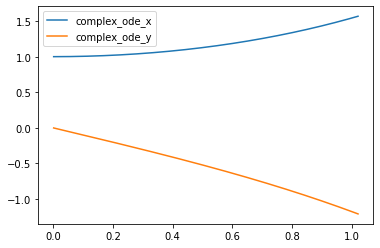

In [15]:
from scipy.integrate import solve_ivp, odeint, complex_ode,ode

# Complex
def rhs_complex(t,z):
    z1,z2 = z
    dz1dt = -np.conj(z2)*1.j
    dz2dt = -np.conj(z1)*1.j
    return [dz1dt,dz2dt]

z0 = [1.,1.]

rn = complex_ode(rhs_complex).set_initial_value(z0, 0.0)
t1 = 1.02
dt = 1./2000.
x_list_cm = []
y_list_cm = []
t_list_cm = []
while rn.successful() and rn.t < t1:
#     print(rn.t,rn.integrate(rn.t+dt))
    x_list_cm.append(rn.integrate(rn.t+dt).real[1])
    y_list_cm.append(rn.integrate(rn.t+dt).imag[1])
    t_list_cm.append(rn.t)
    
# plt.plot(t_list,x_list, label = 'ode_x')
plt.plot(t_list_cm,x_list_cm, label = 'complex_ode_x')
plt.plot(t_list_cm,y_list_cm, label = 'complex_ode_y')

plt.legend()

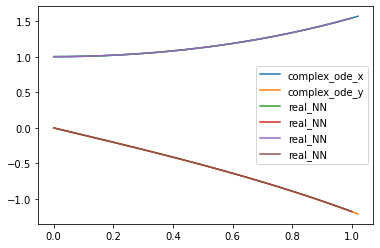

In [16]:
plt.plot(t_list_cm,x_list_cm, label = 'complex_ode_x')
plt.plot(t_list_cm,y_list_cm, label = 'complex_ode_y')
plt.plot(t, z_hat(t) ,label = 'real_NN')
plt.legend()
plt.show()

In [24]:
# with odeint
def rhs(t,z):
    u1,v1,u2,v2= z
    du1dt = -v2
    dv1dt = -u2
    du2dt = -v1
    dv2dt = -u1    
    return [du1dt,dv1dt,du2dt,dv2dt]

u10,v10,u20,v20 = 1.,0.,1.,0.
z0 = np.array([u10,v10,u20,v20])
rhs(t,z0)

solution_x_y_odeint = odeint(func=rhs,y0=z0,t=t.numpy().ravel(),tfirst=True)

In [29]:
solution_x_y_odeint[:,0][:,np.newaxis]

array([[1.        ],
       [1.00000013],
       [1.0000005 ],
       ...,
       [1.5419057 ],
       [1.54249302],
       [1.54308072]])

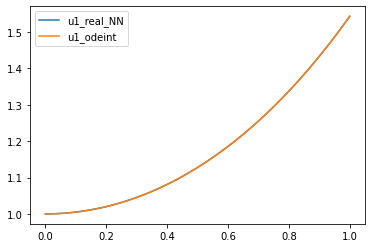

In [33]:
plt.plot(t, z_hat(t)[:,0:1] ,label = 'u1_real_NN')
plt.plot(t, solution_x_y_odeint[:,0][:,np.newaxis] ,label = 'u1_odeint')
plt.legend()
plt.show()

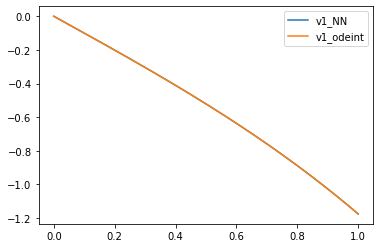

In [34]:
plt.plot(t, z_hat(t)[:,1:2] ,label = 'v1_NN')
plt.plot(t, solution_x_y_odeint[:,1][:,np.newaxis] ,label = 'v1_odeint')
plt.legend()
plt.show()

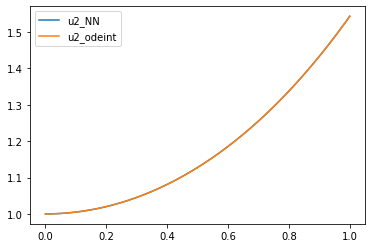

In [35]:
plt.plot(t, z_hat(t)[:,2:3] ,label = 'u2_NN')
plt.plot(t, solution_x_y_odeint[:,2][:,np.newaxis] ,label = 'u2_odeint')
plt.legend()
plt.show()

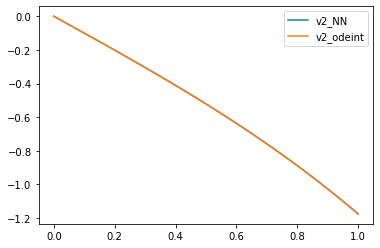

In [36]:
plt.plot(t, z_hat(t)[:,3:] ,label = 'v2_NN')
plt.plot(t, solution_x_y_odeint[:,3][:,np.newaxis] ,label = 'v2_odeint')
plt.legend()
plt.show()

In [18]:
# With batches
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(lr)
pinn = PINN(t, z_hat,z_init,optim)
start = time.time()
losss =  pinn.train_with_adam(batch_mode=True,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in is {(time.time() -start)//60.}s ')

initial loss : 1.183480776489887e-06

called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
called_mish
called_mish

 loss for epoch 0 : 0.22820483148097992

 loss for epoch 1000 : 0.000270181248197332

 loss for epoch 2000 : 0.001130386139266193

 loss for epoch 3000 : 0.00019085322855971754

 loss for epoch 4000 : 0.00013847551599610597
Final loss : 0.00035961702815257013
final loss 0.00035961702815257013 in is 24.0s 
